---
title: Importing the required libraries
jupyter:
  jupytext:
    text_representation:
      extension: .qmd
      format_name: quarto
      format_version: '1.0'
      jupytext_version: 1.16.4
  kernelspec:
    display_name: Python 3
    language: python
    name: python3
---


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Creating the PBT Class

In [42]:
# Defining a class for implementing PBT

class PopulationBasedTraining:
    
    def __init__(self, model, hyperparameters, num_epochs, num_population, num_generations, loss):
        self.model = model
        self.hyperparameters = hyperparameters
        self.num_epochs = num_epochs
        self.num_population = num_population
        self.num_generations = num_generations
        self.loss = loss
        self.listOfAgents = [tf.keras.models.clone_model(model) for i in range(num_population)]
        for i, rate in enumerate(hyperparameters):
            self.listOfAgents[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=float(rate)), loss=self.loss, metrics=['accuracy'])
        
    def train(self, X_train, y_train, X_val, y_val):
        fig, ax = plt.subplots(2,1,figsize=(20,10))
        listOfLossesperAgent = [[]] * self.num_population
        listOfAccuraciesperAgent = [[]] * self.num_population
        for _ in range(self.num_generations):
            for i,agent in enumerate(self.listOfAgents):
                history = agent.fit(X_train, y_train, epochs=self.num_epochs, validation_data=(X_val, y_val))
                listOfLossesperAgent[i].extend(history.history['loss'])
                listOfAccuraciesperAgent[i].extend(history.history['accuracy'])
            self.update_hyperparameters(X_val,y_val)
        for i in range(self.num_population):
            ax[0].plot(listOfLossesperAgent[i], color='blue')
            ax[1].plot(listOfAccuraciesperAgent[i], color='orange')

    def update_hyperparameters(self, X_val, y_val):
        self.listOfAgents = sorted(self.listOfAgents, key=lambda x: x.evaluate(X_val, y_val)[0], reverse=True)
        # for i in range(1, self.num_population//2):
        #     self.listOfAgents[i].set_weights(self.listOfAgents[0].get_weights())
        for i in range(self.num_population//2, self.num_population):
            self.listOfAgents[i].set_weights(self.listOfAgents[i - self.num_population//2].get_weights())
            self.hyperparameters[i] = (np.mean(self.hyperparameters[:self.num_population//2])+self.hyperparameters[i])/2.0
        for i, agent in enumerate(self.listOfAgents):
            agent.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=float(self.hyperparameters[i])), loss=self.loss, metrics=['accuracy'])

    def get_best_agent(self):
        return self.listOfAgents[0]

/Users/mandakausthubh/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 44s 22ms/step - accuracy: 0.8882 - loss: 0.3537 - val_accuracy: 0.9778 - val_loss: 0.0671
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 43s 22ms/step - accuracy: 0.9069 - loss: 0.2878 - val_accuracy: 0.9797 - val_loss: 0.0713
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 43s 19ms/step - accuracy: 0.1025 - loss: 8.6749 - val_accuracy: 0.1009 - val_loss: 2.3229
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - accuracy: 0.1017 - loss: 9580.4551 - val_accuracy: 0.1028 - val_loss: 2.3204
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 18ms/step - accuracy: 0.1006 - loss: 756484.9375 - val_accuracy: 0.0958 - val_loss: 2.3597
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - accuracy: 0.1026 - loss: 6866026.0000 - val_accuracy: 0.0982 - val_loss: 2.5022
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - accuracy: 0.1045 - loss: 107546128.0000 - val_accuracy: 0.0982 - val_loss: 2.7105
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - accuracy: 0.0999 - loss: 170700048.0000 - val_accuracy: 0.0980 - val_loss: 3.0693
18

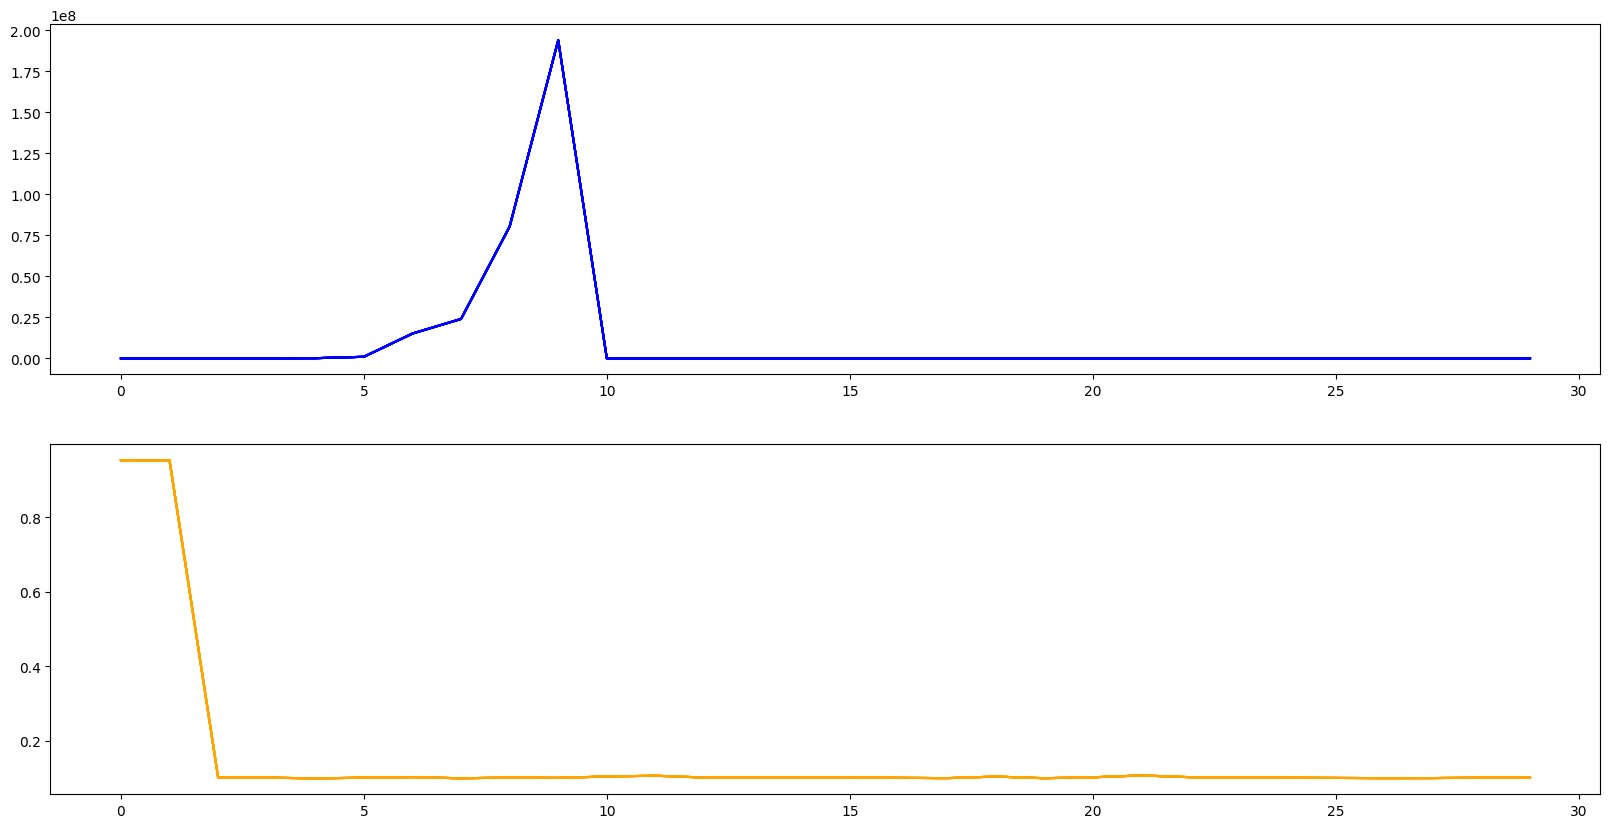

In [43]:
# Trying out PBT on MNIST dataset
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train, X_test = X_train.reshape(-1, 28, 28, 1), X_test.reshape(-1, 28, 28, 1)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

hyperparameters = [0.001, 0.01, 0.1, 0.5, 1, 2, 3, 4, 5, 6]
num_epochs = 1
num_population = 10
num_generations = 3
loss = 'sparse_categorical_crossentropy'

pbt = PopulationBasedTraining(model, hyperparameters, num_epochs, num_population, num_generations, loss)
pbt.train(X_train, y_train, X_test, y_test)
print(pbt.get_best_agent().evaluate(X_test, y_test))

model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test))
print(model.evaluate(X_test, y_test))

In [44]:
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_generations, validation_data=(X_test, y_test))
print(model.evaluate(X_test, y_test))

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - accuracy: 0.9833 - loss: 0.0535 - val_accuracy: 0.9884 - val_loss: 0.0358
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - accuracy: 0.9902 - loss: 0.0316 - val_accuracy: 0.9884 - val_loss: 0.0354
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - accuracy: 0.9926 - loss: 0.0245 - val_accuracy: 0.9879 - val_loss: 0.0380
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9852 - loss: 0.0461
[0.03798602148890495, 0.9879000186920166]


In [45]:
# Creating a model for Cats and Dogs Classifier by reading from the Pets Folder
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os, sys
import cv2

In [46]:
DATADIR = "./src2/PetImages/"
CATEGORIES = ["Dog", "Cat"]

IMG_SIZE = 100
training_data = []

for catergory in CATEGORIES:
    num_category = CATEGORIES.index(catergory)
    path = os.path.join(DATADIR, catergory)
    for image in os.listdir(path):
        try:
            img_arr = cv2.imread(os.path.join(path,image), cv2.IMREAD_GRAYSCALE)
            img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
            training_data.append([img_arr, num_category])
        except Exception as e:
            print(e)
            pass

print(len(training_data))
random.shuffle(training_data)

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


24946


(24946, 100, 100, 1)


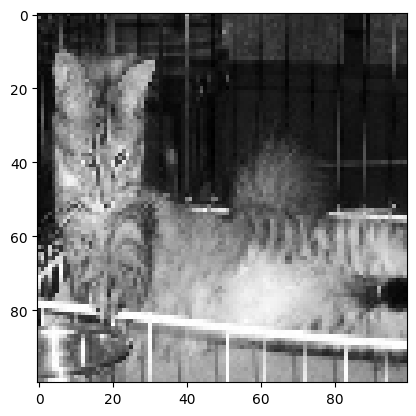

In [47]:
X, Y = [], []

for image, category in training_data:
    X.append(image)
    Y.append(category)

X = np.array(X).reshape(len(X), IMG_SIZE, IMG_SIZE, 1)
X = X.astype('float32')/255

print(X.shape)
plt.imshow(X[0], cmap="gray")

In [48]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(100,100,1)),
        tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)

Y = tf.keras.utils.to_categorical(Y, num_classes=2)
model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])
model.fit(X, Y, batch_size=32, epochs=3)

Epoch 1/3
780/780 ━━━━━━━━━━━━━━━━━━━━ 229s 291ms/step - accuracy: 0.6055 - loss: 0.6481
Epoch 2/3
780/780 ━━━━━━━━━━━━━━━━━━━━ 222s 284ms/step - accuracy: 0.7543 - loss: 0.5045
Epoch 3/3
780/780 ━━━━━━━━━━━━━━━━━━━━ 227s 292ms/step - accuracy: 0.8058 - loss: 0.4193


[0. 1.]
702/702 ━━━━━━━━━━━━━━━━━━━━ 207s 293ms/step - accuracy: 0.5764 - loss: 0.6652 - val_accuracy: 0.7320 - val_loss: 0.5428
702/702 ━━━━━━━━━━━━━━━━━━━━ 210s 296ms/step - accuracy: 0.4976 - loss: 0.7691 - val_accuracy: 0.4892 - val_loss: 0.6942
702/702 ━━━━━━━━━━━━━━━━━━━━ 1036s 1s/step - accuracy: 0.5065 - loss: 101.0051 - val_accuracy: 0.4892 - val_loss: 0.6967
702/702 ━━━━━━━━━━━━━━━━━━━━ 218s 308ms/step - accuracy: 0.4984 - loss: 12684.6494 - val_accuracy: 0.5108 - val_loss: 0.6966
702/702 ━━━━━━━━━━━━━━━━━━━━ 1370s 2s/step - accuracy: 0.5017 - loss: 428674.8750 - val_accuracy: 0.5108 - val_loss: 0.6985
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - accuracy: 0.7264 - loss: 0.5408
79/79 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - accuracy: 0.5057 - loss: 0.6932
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.5057 - loss: 0.6946
79/79 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.4943 - loss: 0.7001
79/79 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.4943 - loss: 0.7027
702/702 

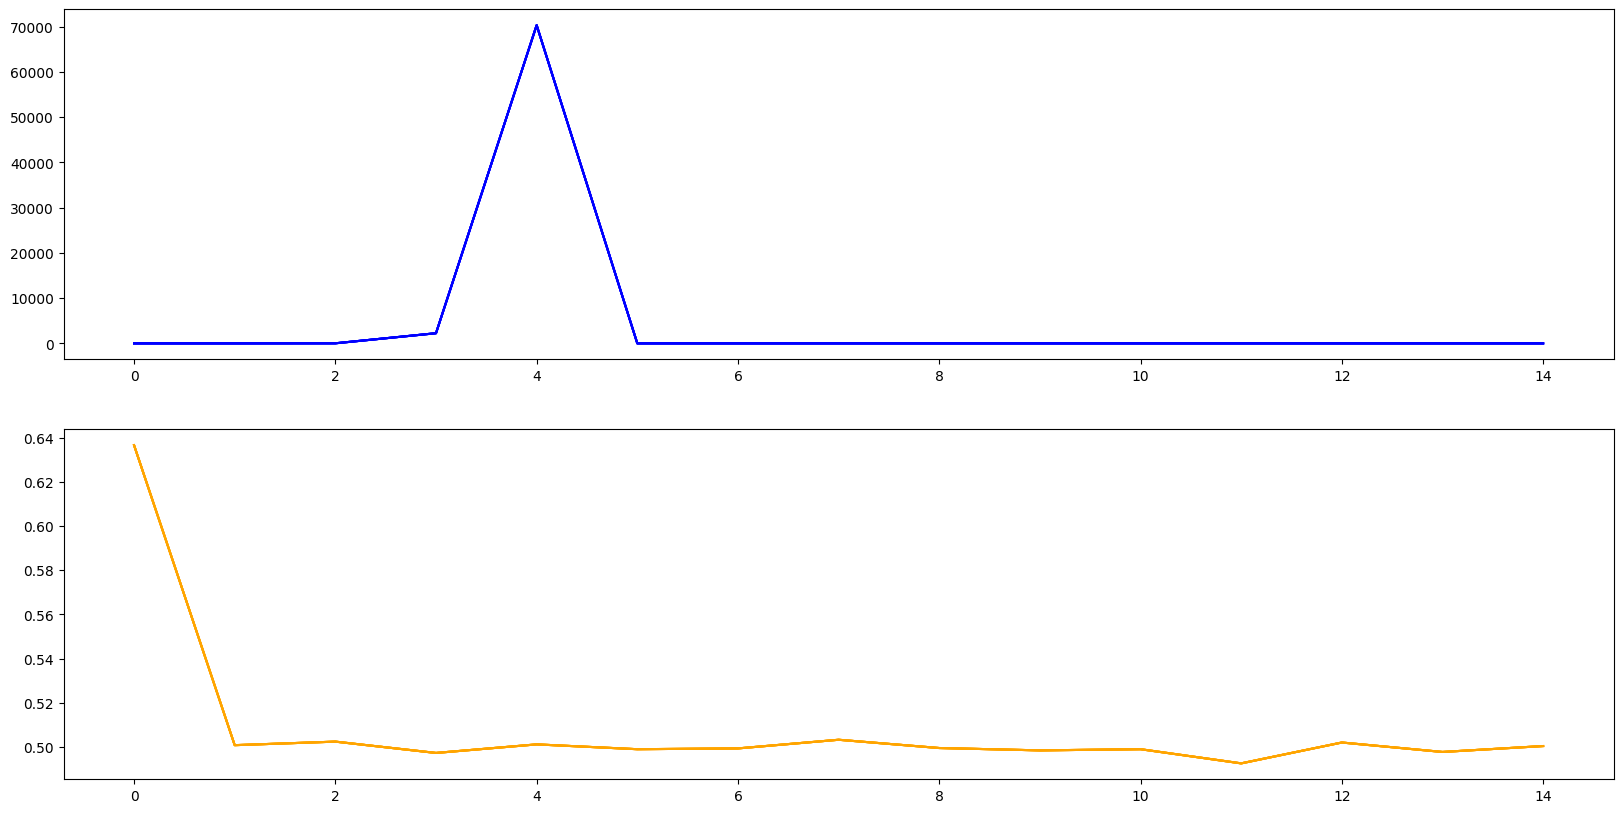

In [49]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(100,100,1)),
        tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)

hyperparameters = [0.001, 0.01, 0.1, 0.5, 1]
num_epochs = 1
num_population = 5
num_generations = 3
loss = 'binary_crossentropy'

X_train, X_test = X[:9*(len(X)//10)], X[9*(len(X)//10):]
y_train, y_test = Y[:9*(len(X)//10)], Y[9*(len(X)//10):]

pbt = PopulationBasedTraining(model, hyperparameters, num_epochs, num_population, num_generations, loss)
print(y_train[0])
pbt.train(X_train=X_train, y_train=y_train, X_val=X_test, y_val=y_test)
# print(pbt.get_best_agent().evaluate(X_test, y_test))

In [50]:
print(pbt.get_best_agent().evaluate(X_test, y_test))

79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.4943 - loss: 0.7003
[0.6966813206672668, 0.5108000040054321]
